In [1]:
import findspark

In [2]:
findspark.init("/opt/manual/spark2")

In [3]:
from pyspark.sql import SparkSession, functions as F
import pandas as pd

In [4]:
# https://github.com/Azure/mmlspark

In [5]:
spark = (SparkSession.builder
        .appName("HChurn Prediction with LightGBM on Spark")
        .master("yarn")
         .config("spark.memory.fraction","0.7")
         .config("spark.memory.storageFraction","0.3")
         .config("spark.executor.cores","2") # lightgbm requires at least 2 cores per task      
         .config("spark.jars.packages","com.microsoft.ml.spark:mmlspark_2.11:0.18.1")
        .enableHiveSupport()
        .getOrCreate())

In [6]:
spark.version

'2.4.7'

In [6]:
! hdfs dfs -ls /user/train/datasets/churn-telecom

Found 3 items
-rw-r--r--   1 train supergroup    5213392 2020-11-19 21:02 /user/train/datasets/churn-telecom/cell2cellholdout.csv
-rw-r--r--   1 train supergroup   13416201 2020-11-19 21:02 /user/train/datasets/churn-telecom/cell2celltrain.csv
drwxr-xr-x   - train supergroup          0 2020-11-19 21:02 /user/train/datasets/churn-telecom/cell2celltrain_clean_parquet


## Read train data

In [7]:
df1 = spark.read.format("parquet") \
.load("hdfs://localhost:9000/user/train/datasets/churn-telecom/cell2celltrain_clean_parquet")

## Explore train data

In [8]:
# Since there are many columns we'd better explore part by part 
df1.select(df1.columns[40:]) \
.limit(46).toPandas()

,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,No,No,Yes,Yes,1.0,0.0,No,No,0.0,4.0,No,0.0,30.0,Yes,1-Highest,Suburban,Professional,No
1,No,No,Yes,Yes,0.0,0.0,Yes,No,0.0,5.0,No,0.0,30.0,No,4-Medium,Suburban,Professional,Yes
2,No,No,No,Yes,0.0,0.0,Yes,No,0.0,6.0,No,0.0,130.0,No,3-Good,Town,Crafts,Yes
3,No,No,No,Yes,0.0,0.0,Yes,No,0.0,6.0,No,0.0,10.0,No,4-Medium,Other,Other,No
4,No,No,Yes,Yes,0.0,0.0,No,Yes,0.0,9.0,No,1.0,10.0,No,1-Highest,Other,Professional,Yes
5,No,Yes,No,Yes,0.0,0.0,Yes,No,0.0,1.0,No,1.0,30.0,No,3-Good,Other,Other,Yes
6,No,Yes,No,Yes,0.0,0.0,No,Yes,0.0,9.0,No,1.0,30.0,No,1-Highest,Other,Self,Yes
7,No,No,No,Yes,0.0,0.0,Yes,No,0.0,6.0,No,0.0,30.0,No,1-Highest,Other,Professional,No
8,No,No,No,Yes,0.0,0.0,Yes,No,0.0,9.0,No,0.0,80.0,No,1-Highest,Other,Other,Yes
9,No,No,Yes,Yes,0.0,0.0,Yes,No,0.0,5.0,No,1.0,30.0,No,3-Good,Other,Professional,No


In [9]:
# Schema change analysis

# MonthlyRevenue, MonthlyMinutes, TotalRecurringCharge, OverageMinutes, PercChangeMinutes, PercChangeRevenues
# Handsets, HandsetModels, CurrentEquipmentDays, AgeHH1, AgeHH2  to integer

# DirectorAssistedCalls, HandsetPrice to float

In [10]:
df1.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Churn: string (nullable = true)
 |-- MonthlyRevenue: double (nullable = true)
 |-- MonthlyMinutes: double (nullable = true)
 |-- TotalRecurringCharge: double (nullable = true)
 |-- DirectorAssistedCalls: double (nullable = true)
 |-- OverageMinutes: double (nullable = true)
 |-- RoamingCalls: double (nullable = true)
 |-- PercChangeMinutes: double (nullable = true)
 |-- PercChangeRevenues: double (nullable = true)
 |-- DroppedCalls: double (nullable = true)
 |-- BlockedCalls: double (nullable = true)
 |-- UnansweredCalls: double (nullable = true)
 |-- CustomerCareCalls: double (nullable = true)
 |-- ThreewayCalls: double (nullable = true)
 |-- ReceivedCalls: double (nullable = true)
 |-- OutboundCalls: double (nullable = true)
 |-- InboundCalls: double (nullable = true)
 |-- PeakCallsInOut: double (nullable = true)
 |-- OffPeakCallsInOut: double (nullable = true)
 |-- DroppedBlockedCalls: double (nullable = true)
 |-- CallForwardingC

In [11]:
# Null check

for(col_name, col_type) in zip(df1.columns, df1.dtypes):
    null_count = df1.filter( (F.col(col_name).isNull()) | (F.col(col_name) == "")).count()
    if(  null_count > 0 ):
        print("{} {} type has {} null values".format(col_name, col_type[1], null_count))

# Distribution of Output/Target variable

In [12]:
df1.select("Churn").groupBy("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No|36335|
|  Yes|14711|
+-----+-----+



<AxesSubplot:>

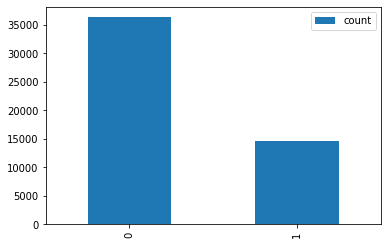

In [13]:
df1.select("Churn").groupBy("Churn").count().toPandas().plot(kind='bar')

# Data Preperation for the Model

In [14]:
categoric_cols = []
numeric_cols = []
discarted_cols = []
label_col = []

In [15]:
# column seperation
for col_name in df1.dtypes:
    if (col_name[0] not in []):
        if (col_name[1] == 'string'):
            categoric_cols.append(col_name[0])
        else: numeric_cols.append(col_name[0])

In [16]:
for col_name in categoric_cols:
    df1.groupBy(col_name).agg(F.count("*").alias("TotalCount")).orderBy(F.desc("TotalCount")).show()

+-----+----------+
|Churn|TotalCount|
+-----+----------+
|   No|     36335|
|  Yes|     14711|
+-----+----------+

+-----------+----------+
|ServiceArea|TotalCount|
+-----------+----------+
|  NYCBRO917|      1684|
|  HOUHOU281|      1510|
|  DALDAL214|      1498|
|  NYCMAN917|      1182|
|  APCFCH703|       783|
|  DALFTW817|       782|
|  SANSAN210|       724|
|  APCSIL301|       670|
|  SANAUS512|       612|
|  SFROAK510|       605|
|  SFRSFR415|       565|
|  NYCQUE917|       533|
|  ATLANE678|       524|
|  PHXPHX602|       512|
|  SFRSCL408|       508|
|  ATLATL678|       507|
|  STLSTL314|       497|
|  OHICOL614|       486|
|  MINMIN612|       481|
|  NEVLVS702|       479|
+-----------+----------+
only showing top 20 rows

+------------+----------+
|ChildrenInHH|TotalCount|
+------------+----------+
|          No|     38678|
|         Yes|     12368|
+------------+----------+

+------------------+----------+
|HandsetRefurbished|TotalCount|
+------------------+----------+
|     

In [17]:
# column seperation after analysis
categoric_cols = []
numeric_cols = []
# Why we discard these? Because they have high cardinality. In other words they have too many distinct categories
# Adding them to model will not do good if not too bad.
discarted_cols = ['CustomerID', 'ServiceArea']
label_col = ['Churn']

In [18]:
for col_name in df1.dtypes:
    if (col_name[0] not in discarted_cols+label_col):
        if (col_name[1] == 'string'):
            categoric_cols.append(col_name[0])
        else: numeric_cols.append(col_name[0])

In [19]:
print(categoric_cols)
print(len(categoric_cols))

['ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser', 'NotNewCellphoneUser', 'OwnsMotorcycle', 'MadeCallToRetentionTeam', 'CreditRating', 'PrizmCode', 'Occupation', 'MaritalStatus']
20


In [20]:
print(numeric_cols)
print(len(numeric_cols))

['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues', 'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService', 'UniqueSubs', 'ActiveSubs', 'Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'RetentionCalls', 'RetentionOffersAccepted', 'ReferralsMadeBySubscriber', 'IncomeGroup', 'AdjustmentsToCreditRating', 'HandsetPrice']
35


In [21]:
print(discarted_cols+label_col)
print(len(discarted_cols+label_col))

['CustomerID', 'ServiceArea', 'Churn']
3


## verification of columns

In [22]:
if len(df1.columns) == (len(categoric_cols)+len(numeric_cols)+len(discarted_cols+label_col)):
    print("Columns verified")
else: print("Columns are not verified")

Columns verified


## Select columns for onehotencoder

In [23]:
# Here we count the distinct categories in categoric columns. If there is more than two,
# we will add those to to_be_onehotencoded_cols list If there is just 2 we don't need to use onehotencoder
# So if distinct category gt 2 we have to add it to_be_onehotencoded_cols list
to_be_onehotencoded_cols = []

for col_name in categoric_cols:
    count = df1.select(col_name).distinct().count()
    if count > 2:
        to_be_onehotencoded_cols.append(col_name)
    print("{} has {} distinct category.".format(col_name, count))
    

ChildrenInHH has 2 distinct category.
HandsetRefurbished has 2 distinct category.
HandsetWebCapable has 2 distinct category.
TruckOwner has 2 distinct category.
RVOwner has 2 distinct category.
Homeownership has 2 distinct category.
BuysViaMailOrder has 2 distinct category.
RespondsToMailOffers has 2 distinct category.
OptOutMailings has 2 distinct category.
NonUSTravel has 2 distinct category.
OwnsComputer has 2 distinct category.
HasCreditCard has 2 distinct category.
NewCellphoneUser has 2 distinct category.
NotNewCellphoneUser has 2 distinct category.
OwnsMotorcycle has 2 distinct category.
MadeCallToRetentionTeam has 2 distinct category.
CreditRating has 7 distinct category.
PrizmCode has 4 distinct category.
Occupation has 8 distinct category.
MaritalStatus has 3 distinct category.


In [24]:
print(to_be_onehotencoded_cols)

['CreditRating', 'PrizmCode', 'Occupation', 'MaritalStatus']


# StringIndexer

In [25]:
from pyspark.ml.feature import StringIndexer

In [26]:
# Will hold stringIndexer objects and column names
my_dict = {}

# Will collect StringIndexer ojects
string_indexer_objs = []

# Will collect StringIndexer output colnames
string_indexer_output_names = []

# Will collect OneHotEncoder output colnames
ohe_col_input_names = []
ohe_col_output_names = []

for col_name in categoric_cols:
    my_dict[col_name+"_indexobj"] = StringIndexer() \
    .setHandleInvalid('skip') \
    .setInputCol(col_name) \
    .setOutputCol(col_name+"_indexed")
    
    string_indexer_objs.append(my_dict.get(col_name+"_indexobj"))
    string_indexer_output_names.append(col_name+"_indexed")
    if col_name in to_be_onehotencoded_cols:
        ohe_col_input_names.append(col_name+"_indexed")
        ohe_col_output_names.append(col_name+"_ohe")

In [27]:
print(string_indexer_objs)
print(len(string_indexer_objs))

[StringIndexer_ae4899dc030c, StringIndexer_821dc8bc55dc, StringIndexer_69e5c23854c4, StringIndexer_b23b81c39015, StringIndexer_3444b55815bf, StringIndexer_b1ae2ce18171, StringIndexer_87f9f2668751, StringIndexer_88cede68cf38, StringIndexer_998bb328f98e, StringIndexer_1ca7497bf55a, StringIndexer_2b69b5bef2a0, StringIndexer_96b6bb2e6e62, StringIndexer_70d958f11b02, StringIndexer_0e3b313e32bf, StringIndexer_7b2e6d29c2a6, StringIndexer_013729b2f102, StringIndexer_6b655a101463, StringIndexer_077460bf9e12, StringIndexer_f9cd2c3632dc, StringIndexer_eca13a55ada5]
20


In [28]:
print(string_indexer_output_names)
print(len(string_indexer_output_names))

['ChildrenInHH_indexed', 'HandsetRefurbished_indexed', 'HandsetWebCapable_indexed', 'TruckOwner_indexed', 'RVOwner_indexed', 'Homeownership_indexed', 'BuysViaMailOrder_indexed', 'RespondsToMailOffers_indexed', 'OptOutMailings_indexed', 'NonUSTravel_indexed', 'OwnsComputer_indexed', 'HasCreditCard_indexed', 'NewCellphoneUser_indexed', 'NotNewCellphoneUser_indexed', 'OwnsMotorcycle_indexed', 'MadeCallToRetentionTeam_indexed', 'CreditRating_indexed', 'PrizmCode_indexed', 'Occupation_indexed', 'MaritalStatus_indexed']
20


In [29]:
print(ohe_col_input_names)
print(len(ohe_col_input_names))

['CreditRating_indexed', 'PrizmCode_indexed', 'Occupation_indexed', 'MaritalStatus_indexed']
4


In [30]:
print(ohe_col_output_names)
print(len(ohe_col_output_names))

['CreditRating_ohe', 'PrizmCode_ohe', 'Occupation_ohe', 'MaritalStatus_ohe']
4


# OnehotEncoder

In [31]:
from pyspark.ml.feature import OneHotEncoderEstimator

In [32]:
encoder = OneHotEncoderEstimator() \
.setInputCols(ohe_col_input_names) \
.setOutputCols(ohe_col_output_names)

# VectorAssembler

In [33]:
from pyspark.ml.feature import VectorAssembler

In [34]:
# We have to exclude onehotencoded categoric cols from stringIndexer cols
string_indexer_col_names_ohe_exluded = list(set(string_indexer_output_names).difference(set(ohe_col_input_names)))
string_indexer_col_names_ohe_exluded

['NonUSTravel_indexed',
 'NotNewCellphoneUser_indexed',
 'ChildrenInHH_indexed',
 'HasCreditCard_indexed',
 'MadeCallToRetentionTeam_indexed',
 'RespondsToMailOffers_indexed',
 'Homeownership_indexed',
 'RVOwner_indexed',
 'HandsetWebCapable_indexed',
 'OwnsComputer_indexed',
 'HandsetRefurbished_indexed',
 'TruckOwner_indexed',
 'OwnsMotorcycle_indexed',
 'BuysViaMailOrder_indexed',
 'OptOutMailings_indexed',
 'NewCellphoneUser_indexed']

## column verification

In [35]:
if len(categoric_cols) == (len(string_indexer_col_names_ohe_exluded)+len(ohe_col_output_names)):
    print("Columns verified")
else: print("Columns are not verified")

Columns verified


In [36]:
assembler = VectorAssembler().setHandleInvalid("skip") \
.setInputCols(numeric_cols+string_indexer_col_names_ohe_exluded+ohe_col_output_names) \
.setOutputCol('unscaled_features')

# LabelIndexer

In [37]:
label_indexer = StringIndexer().setHandleInvalid("skip") \
.setInputCol(label_col[0]) \
.setOutputCol("label")

# Feature Scaling

In [38]:
from pyspark.ml.feature import StandardScaler

In [39]:
scaler = StandardScaler().setInputCol("unscaled_features").setOutputCol("scaled_features")

# PCA

In [40]:
from pyspark.ml.feature import PCA

In [41]:
pca = PCA().setInputCol("scaled_features").setK(10).setOutputCol("features")

# Estimator

In [43]:
from mmlspark.lightgbm import LightGBMClassifier

In [44]:
estimator = LightGBMClassifier(learningRate=0.3,
                           numIterations=200,
                           numLeaves=20,
                           featuresCol='features',
                           labelCol='label',
                           isUnbalance=True)

# Pipeline

In [45]:
from pyspark.ml import Pipeline

In [46]:
pipeline_obj = Pipeline().setStages(string_indexer_objs+[encoder, assembler, label_indexer, scaler, pca, estimator])

In [ ]:
# Split data

In [50]:
train_df, test_df = df1.randomSplit([0.8, 0.2], seed=142)

In [51]:
print(train_df.count())
print(test_df.count())

40805
10241


# Train Model

In [52]:
pipeline_model = pipeline_obj.fit(train_df)

# Save the model

In [53]:
pipeline_model.stages[-1].write().overwrite().save("saved_models/lightgbm_churn_pca10")

# Prediction

In [54]:
transformed_df = pipeline_model.transform(test_df)

In [55]:
transformed_df.select('label','prediction','probability','rawPrediction').show(truncate=False)

+-----+----------+-----------------------------------------+------------------------------------------+
|label|prediction|probability                              |rawPrediction                             |
+-----+----------+-----------------------------------------+------------------------------------------+
|0.0  |1.0       |[0.4562176701118613,0.5437823298881387]  |[-0.5437823298881387,0.5437823298881387]  |
|0.0  |0.0       |[2.102333003227442,-1.1023330032274423]  |[1.1023330032274423,-1.1023330032274423]  |
|0.0  |1.0       |[0.7632705594919944,0.2367294405080056]  |[-0.2367294405080056,0.2367294405080056]  |
|0.0  |0.0       |[1.8093703165253254,-0.8093703165253253] |[0.8093703165253253,-0.8093703165253253]  |
|0.0  |1.0       |[0.6734445596582923,0.32655544034170764] |[-0.32655544034170764,0.32655544034170764]|
|0.0  |0.0       |[1.7771846873326411,-0.7771846873326412] |[0.7771846873326412,-0.7771846873326412]  |
|1.0  |0.0       |[3.4090835887151716,-2.4090835887151716] |[2.4

# Evaluate the model

In [56]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [57]:
evaluator = BinaryClassificationEvaluator()

In [59]:
evaluator.evaluate(transformed_df)

0.5710878139549131

In [60]:
evaluator.getMetricName()

'areaUnderROC'

In [64]:
transformed_df.select('label','prediction','probability','rawPrediction') \
.filter("prediction == 1.0") \
.show(truncate=False)

+-----+----------+----------------------------------------+------------------------------------------+
|label|prediction|probability                             |rawPrediction                             |
+-----+----------+----------------------------------------+------------------------------------------+
|1.0  |1.0       |[0.16076090914580143,0.8392390908541986]|[-0.8392390908541986,0.8392390908541986]  |
|1.0  |1.0       |[0.5002971910823228,0.49970280891767715]|[-0.49970280891767715,0.49970280891767715]|
|0.0  |1.0       |[0.8191176294559761,0.18088237054402387]|[-0.18088237054402387,0.18088237054402387]|
|1.0  |1.0       |[0.18698943850768945,0.8130105614923105]|[-0.8130105614923105,0.8130105614923105]  |
|0.0  |1.0       |[0.05904156264476623,0.9409584373552338]|[-0.9409584373552338,0.9409584373552338]  |
|1.0  |1.0       |[-0.6487842000492643,1.6487842000492643]|[-1.6487842000492643,1.6487842000492643]  |
|0.0  |1.0       |[0.3952176887019184,0.6047823112980816] |[-0.6047823112

In [65]:
transformed_df.select('label','prediction','probability','rawPrediction') \
.withColumn("score", F.col('probability').cast('string')).show()

+-----+----------+--------------------+--------------------+--------------------+
|label|prediction|         probability|       rawPrediction|               score|
+-----+----------+--------------------+--------------------+--------------------+
|  1.0|       1.0|[0.16076090914580...|[-0.8392390908541...|[0.16076090914580...|
|  1.0|       1.0|[0.50029719108232...|[-0.4997028089176...|[0.50029719108232...|
|  0.0|       1.0|[0.81911762945597...|[-0.1808823705440...|[0.81911762945597...|
|  0.0|       0.0|[1.44410920232326...|[0.44410920232326...|[1.44410920232326...|
|  1.0|       1.0|[0.18698943850768...|[-0.8130105614923...|[0.18698943850768...|
|  0.0|       0.0|[2.22036560841634...|[1.22036560841634...|[2.22036560841634...|
|  0.0|       0.0|[1.54740170905303...|[0.54740170905303...|[1.54740170905303...|
|  0.0|       0.0|[1.38594331792427...|[0.38594331792427...|[1.38594331792427...|
|  0.0|       0.0|[1.03985462042266...|[0.03985462042266...|[1.03985462042266...|
|  0.0|       0.

In [66]:
transformed_df.select('label','prediction','probability','rawPrediction').printSchema()

root
 |-- label: double (nullable = false)
 |-- prediction: double (nullable = false)
 |-- probability: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)



# Get churn score from probability

In [67]:
import pyspark.sql.functions as F
import pyspark.sql.types as T

to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))
score_df = transformed_df.select('CustomerID','label','prediction','probability','rawPrediction') \
.withColumn('score', to_array('probability')[1] * 1000)

In [68]:
score_df.filter("prediction == 1.0").show()

+----------+-----+----------+--------------------+--------------------+---------+
|CustomerID|label|prediction|         probability|       rawPrediction|    score|
+----------+-----+----------+--------------------+--------------------+---------+
|   3000002|  1.0|       1.0|[0.16076090914580...|[-0.8392390908541...|839.23914|
|   3000010|  1.0|       1.0|[0.50029719108232...|[-0.4997028089176...|499.70282|
|   3000014|  0.0|       1.0|[0.81911762945597...|[-0.1808823705440...|180.88237|
|   3000026|  1.0|       1.0|[0.18698943850768...|[-0.8130105614923...|813.01056|
|   3000054|  0.0|       1.0|[0.05904156264476...|[-0.9409584373552...|940.95844|
|   3000082|  1.0|       1.0|[-0.6487842000492...|[-1.6487842000492...|1648.7842|
|   3000102|  0.0|       1.0|[0.39521768870191...|[-0.6047823112980...| 604.7823|
|   3000118|  0.0|       1.0|[0.79214609757219...|[-0.2078539024278...| 207.8539|
|   3000122|  1.0|       1.0|[-0.6508730394595...|[-1.6508730394595...| 1650.873|
|   3000158|  1.

# Top 20 Costumers most likely to churn

In [69]:
score_df.orderBy(F.desc("score")).show()

+----------+-----+----------+--------------------+--------------------+---------+
|CustomerID|label|prediction|         probability|       rawPrediction|    score|
+----------+-----+----------+--------------------+--------------------+---------+
|   3161590|  1.0|       1.0|[0.32266325221542...|[-0.6773367477845...|1226.0823|
|   3252322|  0.0|       1.0|[0.47689756811488...|[-0.5231024318851...|1135.0568|
|   3221118|  0.0|       1.0|[0.61392526382615...|[-0.3860747361738...|1030.9592|
|   3363994|  0.0|       1.0|[0.40595818216235...|[-0.5940418178376...|1015.1546|
|   3183090|  1.0|       1.0|[0.03619284076005...|[-0.9638071592399...| 963.8072|
|   3363198|  1.0|       1.0|[0.03765840728405...|[-0.9623415927159...| 962.3416|
|   3298874|  1.0|       1.0|[0.04168703552198...|[-0.9583129644780...|  958.313|
|   3153374|  1.0|       1.0|[0.04330661618327...|[-0.9566933838167...| 956.6934|
|   3212006|  1.0|       1.0|[0.04354326766148...|[-0.9564567323385...| 956.4567|
|   3014814|  1.

In [70]:
score_df.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- label: double (nullable = false)
 |-- prediction: double (nullable = false)
 |-- probability: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- score: float (nullable = true)



# Hyperparameter Tuning

In [72]:
from pyspark.ml.tuning import CrossValidatorModel, ParamGridBuilder, CrossValidator

In [74]:
paramGrid = ParamGridBuilder() \
.addGrid(pca.k, [5, 10]) \
.addGrid(estimator.numLeaves, [5, 20]) \
.build()

In [75]:
crossval = CrossValidator(estimator=pipeline_obj,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5) 

In [76]:
cvModel = crossval.fit(df1)

In [77]:
type(cvModel)

pyspark.ml.tuning.CrossValidatorModel

In [78]:
cvModel.params

[Param(parent='CrossValidatorModel_fb925bf2b501', name='estimator', doc='estimator to be cross-validated'),
 Param(parent='CrossValidatorModel_fb925bf2b501', name='estimatorParamMaps', doc='estimator param maps'),
 Param(parent='CrossValidatorModel_fb925bf2b501', name='evaluator', doc='evaluator used to select hyper-parameters that maximize the validator metric'),
 Param(parent='CrossValidatorModel_fb925bf2b501', name='seed', doc='random seed.')]

In [79]:
bestModel = cvModel.bestModel

In [80]:
evaluator.evaluate(bestModel.transform(df1))

0.6692156342748101

In [81]:
evaluator.evaluate(cvModel.transform(df1))

0.6692156342748186

In [61]:
spark.stop()